# PyDSGE Example - Small New Keynesian Model
## Author: Gustavo Amarante
This jupyter notebook is an example on how to implement the basic new keynesian model. The details of the model and 
parameters interpretations can be found in [Galí (2008)](https://www.amazon.com/Monetary-Policy-Inflation-Business-Cycle/dp/0691133166) 
and a full step-by-step derivation of the model equations is in 
[Bergholt (2012)](https://bergholt.weebly.com/uploads/1/1/8/4/11843961/the_basic_new_keynesian_model_-_drago_bergholt.pdf).

The linearized version of the model is given by the following equations:

$
\begin{align*}
\tilde{y}_{t} & =E_{t}\left(\tilde{y}_{t+1}\right)-\frac{1}{\sigma}\left[\hat{i}_{t}-E_{t}\left(\pi_{t+1}\right)\right]+\psi_{ya}^{n}\left(\rho_{a}-1\right)a_{t}\\
\pi_{t} & =\beta E_{t}\left(\pi_{t+1}\right)+\kappa\tilde{y}_{t}+\sigma_{\pi}\varepsilon_{t}^{\pi}\\
\hat{i}_{t} & =\phi_{\pi}\pi_{t}+\phi_{y}\tilde{y}_{t}+v_{t}\\
a_{t} & =\rho_{a}a_{t-1}+\sigma_{a}\varepsilon_{t}^{a}\\
v_{t} & =\rho_{v}v_{t-1}+\sigma_{v}\varepsilon_{t}^{v}
\end{align*}
$

where the following parameters are given by:

$
\psi_{ya}^{n}=\frac{1+\varphi}{\sigma\left(1-\alpha\right)+\varphi+\alpha}\qquad\kappa=\frac{\left(1-\theta\right)\left(1-\theta\beta\right)\left[\sigma\left(1-\alpha\right)+\varphi+\alpha\right]}{\theta\left(1-\alpha+\alpha\epsilon\right)}
$

We also need to write the expectations of time $t+1$ variables as time-$t$ variables. The relationship between variable 
expectations and the effective value is just the expectational error.

$
\begin{align*}
\tilde{y}_{t+1} & =ex_{t}^{y}+\eta_{t+1}^{y}\\
\pi_{t+1} & =ex_{t}^{\pi}+\eta_{t+1}^{\pi}
\end{align*}
$

where $ex_{t}^{y}=E_{t}\left(\tilde{y}_{t+1}\right)$.

So we have 7 endogenous variables, 3 exogenous shocks $\varepsilon$ and 2 expectational errors $\eta$ that compose the 
state equations of the model. We also need to specify the set of observation equations, which we will assume that only 
the output gap, inflation and interest rate are observable variables. 

$
\begin{align*}
output\_gap_{t} & =\tilde{y}_{t}\\
inflation_{t} & =\pi_{t}\\
interest\_rate_{t} & =\left(\frac{1}{\beta}-1\right)+\hat{i}_{t}\\
\end{align*}
$

These are the sections of this notebook represent the required steps of a DSGE:
* Especification
* Calibration
* Simulation
* Estimation
* Analysis

In [4]:
import sys
sys.path.append("/Users/gusamarante/PycharmProjects/pydsge")
sys.path.append("/Users/gusamarante/PycharmProjects/pykalman")

---
# Imports
Your imports should include `symbols` and `Matrix` from the [`sympy` library](https://www.sympy.org/en/index.html), as 
these are required for variables and model declaration.

In [5]:
from pydsge import DSGE
import matplotlib.pyplot as plt
from sympy import symbols, Matrix

---
# Model Especification
## Variable Declaration
Declare all of the endogenous variables at time-$t$ as symbols and create a `Matrix` object with them.

In [6]:
y, pi, i, a, v, exp_y, exp_pi = symbols('y, pi, i, a, v, exp_y, exp_pi')
endog = Matrix([y, pi, i, a, v, exp_y, exp_pi])

Declare all of the endogenous variables at time-$t-1$ as symbols and create a `Matrix` object with them. The convention 
in this notebook is to  add an `l` (for "lagged") at the end of the variable name.

In [7]:
yl, pil, il, al, vl, exp_yl, exp_pil = symbols('yl, pil, il, al, vl, exp_yl, exp_pil')
endogl = Matrix([yl, pil, il, al, vl, exp_yl, exp_pil])

Declare all of the exogenous shocks $\varepsilon$ as symbols and create a `Matrix` object with them.

In [8]:
eps_a, eps_v, eps_pi = symbols('eps_a, eps_v, eps_pi')
exog = Matrix([eps_a, eps_v, eps_pi])

Declare all of the expectational errors $\eta$ as symbols and create a `Matrix` object with them.

In [9]:
eta_y, eta_pi = symbols('eta_y, eta_pi')
expec = Matrix([eta_y, eta_pi])


Declare all of the parameter as symbols and create a `Matrix` object with them. 
Summary parameters (functions of other parameters) do not need to be inside the matrix object, they only need to be 
defined by their formula.

In [10]:
sigma, varphi, alpha, beta, theta, phi_pi, phi_y, rho_a, sigma_a, rho_v, sigma_v, sigma_pi = \
    symbols('sigma, varphi, alpha, beta, theta, phi_pi, phi_y, rho_a, sigma_a, rho_v, sigma_v, sigma_pi')

psi_nya = (1 + varphi) / (sigma*(1-alpha) + varphi + alpha)
kappa = (1 - theta)*(1 - theta * beta)*(sigma*(1-alpha) + varphi + alpha)

## State Equations 
Given the set of linearized equilibrium conditions described in the beggining of thie notebook, put all of the terms 
to one side of the equation so that the system of equations is equal to zero. Since all of our variable and parameter 
names are symbols, the equations will be correctly interpreted as symbolic expressions. These expressions should also 
go into a `Matrix` object. This set of equations should include only the state equations of the system. 

In [11]:
eq1 = y - exp_y + (1/sigma)*(i - exp_pi) - psi_nya * (rho_a - 1) * a
eq2 = pi - beta * exp_pi - kappa * y - sigma_pi * eps_pi
eq3 = i - phi_pi * pi - phi_y * y - v
eq4 = a - rho_a * al - sigma_a * eps_a
eq5 = v - rho_v * vl - sigma_v * eps_v
eq6 = y - exp_yl - eta_y
eq7 = pi - exp_pil - eta_pi

equations = Matrix([eq1, eq2, eq3, eq4, eq5, eq6, eq7])

## Observation Equations
Using the observation equations described in the beggining of thie notebook, the expression for the observable variables
(linear function of the state variables) should be on the right side of the equation. These expressions should also go 
into a `Matrix` object. This set of equations  should include only the observation equations of the system. 

In [12]:
obs01 = y
obs02 = pi
obs03 = 1/beta - 1 + i

obs_equations = Matrix([obs01, obs02, obs03])

---
# Model Calibration
Now that we have decribed the full set of equilibrium conditions of the models, we can calibrate the parameters. We will
save the simulated data to illuestrate the estimation processo later on. To calibrate a model, all you need is a 
dictionary where the keys are the parameter symbols (***not*** the string with their names) and the values are their 
respective calibration value. The values below will be our "true" parameters. Later in this notebook we will estimate
them.

In [13]:
calib_dict = {sigma: 1.3,
              varphi: 1,
              alpha: 0.4,
              beta: 0.997805,
              theta: 0.75,
              phi_pi: 1.5,
              phi_y: 0.2,
              rho_a: 0.9,
              sigma_a: 1.1,
              rho_v: 0.5,
              sigma_v: 0.3,
              sigma_pi: 0.8}

to build the DSGE object we just have to pass the `Matrix` objects that we created and the calibration dictionary.

In [14]:
dsge_simul = DSGE(endog=endog, 
                  endogl=endogl, 
                  exog=exog, 
                  expec=expec, 
                  state_equations=equations,
                  obs_equations=obs_equations,
                  calib_dict=calib_dict)

Since we passed a calibration dictionary, the model already knows that it only has to substitute the calibration values
in their respective symbolic representaions and solves the model. Just by writing the statement above, the object passed  to `dsge_simul` already computed everything.

To check if the calbration values yield a solution or not, the model has the `.eu` attibute, which mirrors the definition from
the original *Sims (2002)* `gensys.m` function. It represents the existance (e) and uniqueness (u) of the solution of the model. 
If the first entry is equal to 1 it means the model has a solution and if the second entry is equal to 1 it means that
the solution is unique.

In [15]:
print(dsge_simul.eu)

[1, 1]


---
# Simulation

There is a method to simulate data from the calibrated model. Here we are using a random seed for replication purposes.
We will generate the data and plot the observed variables.

<AxesSubplot:>

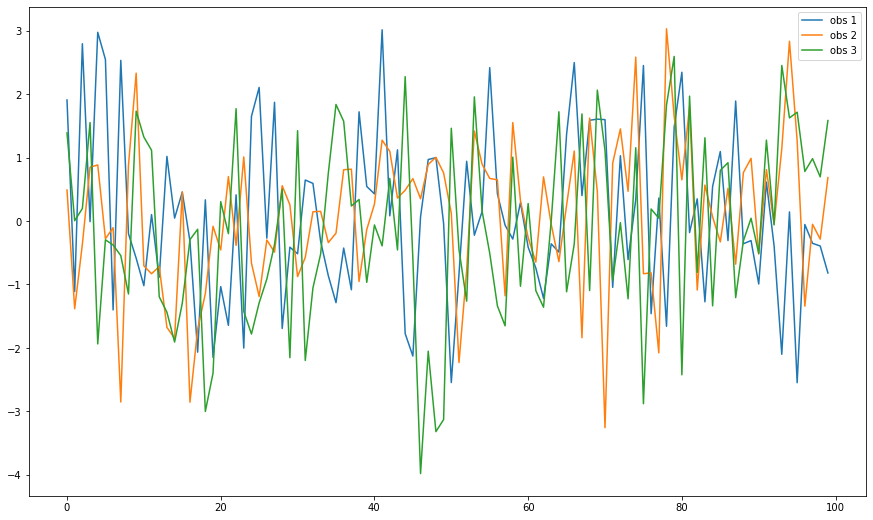

In [18]:
df_obs, df_states = dsge_simul.simulate(n_obs=200, random_seed=1)

# Discard the beginning of the simulation
df_states = df_states.tail(100).reset_index(drop=True)
df_obs = df_obs.tail(100).reset_index(drop=True)

df_obs.plot(figsize=(15, 9))

The `irf` method computed the impulse-response functions of the calibrated model and returns a MultiIndex DataFrame, with (shock, period) as the index and variables as the columns. It also has functionality to plot the IRFs.

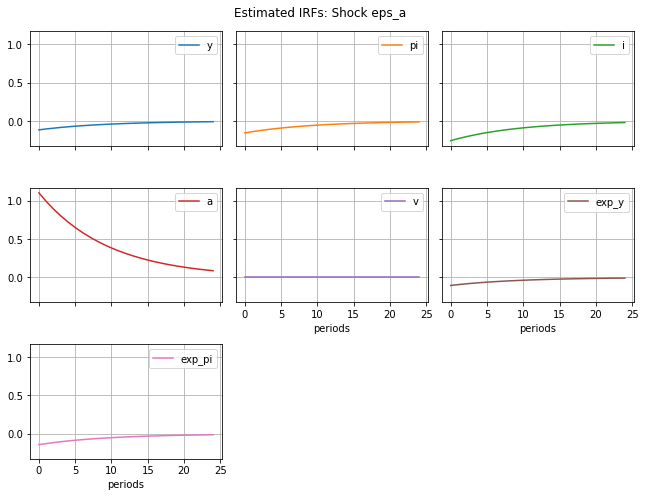

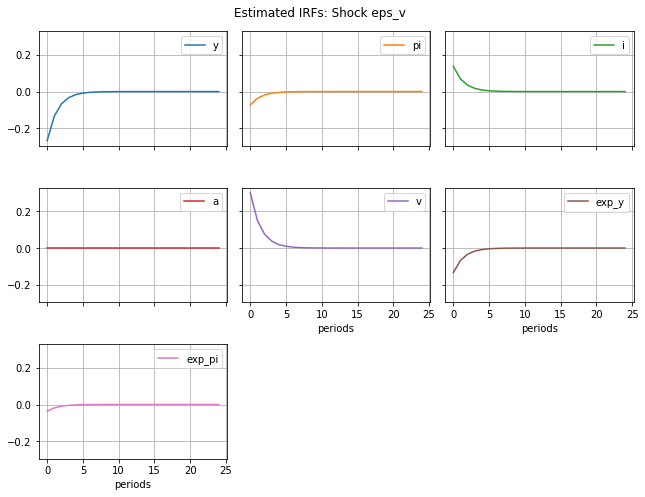

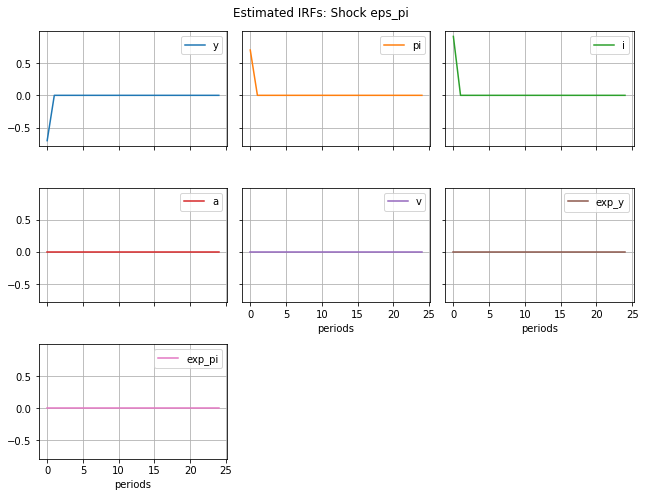

In [19]:
df_irf = dsge_simul.irf(periods=24, show_charts=True)

---
# Estimation
The estimation DSGEs usually comes with the problem of identificiationm of some of their parameters. To handle this 
problem, the parameters that are not identified usually are calibrated prior to estimation. In the cell below, we first create a dictionary with only the parameters we want to calibrate and then create a `Matrix` object of the parameters that are going to be estimated.

In [21]:
calib_param = {varphi: 1, alpha: 0.4, beta: 0.997805}
estimate_param = Matrix([sigma, theta, phi_pi, phi_y, rho_a, sigma_a, rho_v, sigma_v, sigma_pi])

Since we use bayesian estimation with MCMC we need to define the priors of the parameters that are going to be 
estimated. The available distributions for priors are Beta, Gamma, Inverse Gamma, Uniform and Normal. For each prior you 
have to choose a mean and a standard deviation. The table below shows how the mean and standard deviations are related 
to the distribution parameters. There is also a `label` entry for each parameter, which will be used for legends and 
titles on the output charts, and notice that it accepts $\LaTeX$ entries.

|Distribution|Parameter $a$|Parameter $b$|Support           |Mean           |Variance                                           |
|------------|-------------|-------------|------------------|---------------|---------------------------------------------------|
|Beta        |$a>0$ (shape)|$b>0$ (shape)|$\left[0,1\right]$|$\frac{a}{a+b}$|$\frac{ab}{\left(a+b\right)^{2}\left(a+b+1\right)}$|
|Gamma	     |$a>0$ (shape)|$b>0$ (scale)|$\mathbb{R}^{+}$  |$ab$           |$ab^{2}$                                           |
|Inverse Gamma|$a>0$ (shape)|$b>0$ (scale)|$\mathbb{R}^{+}$ |$\frac{\beta}{\alpha-1}$|$\frac{\beta^{2}}{\left(\alpha-1\right)^{2}\left(\alpha-2\right)}$|
|Uniform     |$a\in\mathbb{R}$ (lower bound)|b>a (upper bound)|$\left[a,b\right]$|$\frac{a+b}{2}$|$\frac{\left(b-a\right)^{2}}{12}$|
|Normal      |$a\in\mathbb{R}$ (mean)|$b>0$ (std)|$\mathbb{R}$|$a$|$b^{2}$|

In [22]:
prior_dict = {sigma:    {'dist': 'normal',   'mean':  1.30, 'std': 0.20, 'label': '$\\sigma$'},
              theta:    {'dist': 'beta',     'mean':  0.60, 'std': 0.20, 'label': '$\\theta$'},
              phi_pi:   {'dist': 'normal',   'mean':  1.50, 'std': 0.35, 'label': '$\\phi_{\\pi}$'},
              phi_y:    {'dist': 'gamma',    'mean':  0.25, 'std': 0.10, 'label': '$\\phi_{y}$'},
              rho_a:    {'dist': 'beta',     'mean':  0.50, 'std': 0.25, 'label': '$\\rho_a$'},
              sigma_a:  {'dist': 'invgamma', 'mean':  0.50, 'std': 0.25, 'label': '$\\sigma_a$'},
              rho_v:    {'dist': 'beta',     'mean':  0.50, 'std': 0.25, 'label': '$\\rho_v$'},
              sigma_v:  {'dist': 'invgamma', 'mean':  0.50, 'std': 0.25, 'label': '$\\sigma_v$'},
              sigma_pi: {'dist': 'invgamma', 'mean':  0.50, 'std': 0.25, 'label': '$\\sigma_{\\pi}$'}}

dsge = DSGE(endog=endog, 
            endogl=endogl, 
            exog=exog, 
            expec=expec, 
            state_equations=equations,
            estimate_params=estimate_param,
            calib_dict=calib_param,
            obs_equations=obs_equations,
            prior_dict=prior_dict,
            obs_data=df_obs,
            verbose=True)

After the model is declared, you can to pass three arguments to the `estimate` method. 

The argument `file_path` is the address for where you would like to save the HDF file with the generated MCMC chains.  This file type was chosen because of its fast read/write speed (on the other hand, the file is very large). Every 100 iterations, the chains will be saved to this file, which ensure that the MCMC chains are not lost on the event that the execution is interrupted. If you pass the adress of a file that already exists, it will read the chains from the file and continue from where it stoped. If the file passed does not exist, it will be created and before the MCMC step starts the `csminwel` optimization will find the posterior mode.

The `nsim` (default: 1000) is the size of the chain and `ck` (deafult: 0.2) is the scale parameter for the
Accpetance-Rejection part of the metropolis-hasting algorithm, which should be set in order to match your desired 
acceptance rate.

If `verbose` is true, the steps of the estimation (optimization and MCMC) will be printed to the user.

In [23]:
dsge.estimate(file_path='example_snkm.h5', nsim=2000, ck=0.3)

f at the beginning of iteration 1 is 524691.654607677
Improvement on iteration 1 was 5018.874481565028


f at the beginning of iteration 2 is 519672.780126112
Improvement on iteration 2 was 460.21694591012783


f at the beginning of iteration 3 is 519212.56318020186
Improvement on iteration 3 was 188.66922847926617


f at the beginning of iteration 4 is 519023.8939517226
Improvement on iteration 4 was 185.33461659605382


f at the beginning of iteration 5 is 518838.55933512654
Improvement on iteration 5 was 147.75005035992945


f at the beginning of iteration 6 is 518690.8092847666
Improvement on iteration 6 was 53.51791460841196


f at the beginning of iteration 7 is 518637.2913701582
Improvement on iteration 7 was 2.6717723121400923


f at the beginning of iteration 8 is 518634.61959784606
Improvement on iteration 8 was 88.77543847612105


f at the beginning of iteration 9 is 518545.84415936994


/Users/gusamarante/PycharmProjects/pydsge/pydsge/pycsminwel.py:274: UserWarning: Possible inaccuracy in the Hessian matrix
  warn('Possible inaccuracy in the Hessian matrix')


Improvement on iteration 9 was 6.011767842981499


f at the beginning of iteration 10 is 518539.83239152696
Improvement on iteration 10 was 73.7480929333251


f at the beginning of iteration 11 is 518466.08429859363
Improvement on iteration 11 was 190.4155716895475


f at the beginning of iteration 12 is 518275.6687269041
Improvement on iteration 12 was 42.11627369263442


f at the beginning of iteration 13 is 518233.55245321145
Improvement on iteration 13 was 156.37098695343593


f at the beginning of iteration 14 is 518077.181466258
Improvement on iteration 14 was 105.05057850625599


f at the beginning of iteration 15 is 517972.13088775176
Improvement on iteration 15 was 332.7746128683211


f at the beginning of iteration 16 is 517639.35627488344
Improvement on iteration 16 was 37.76652485807426


f at the beginning of iteration 17 is 517601.58975002536
Improvement on iteration 17 was 14.478461557941046


f at the beginning of iteration 18 is 517587.1112884674
Improvement on iterati

Metropolis-Hastings: 100%|██████████████████| 1999/1999 [11:19<00:00,  2.94it/s]

Acceptance rate: 42.95 percent


The `eval_chain` method does not return any output, but it generates two charts, a posterior table as an atribute and sets the posterior mode as the parameters to compute the model solution. 

The first chart contains the subplots of the MCMC chains of each parameter and the second chart is the prior (countinous line) and posterior (histogram) for each parameter. The `burnin` parameter defines how much of
the beggining of the chain is droped out of the analysis. If the input is a `float` between 0 and 1, that percentage of the beggining of the chain will be dropped, and if it is an `int` and bigger than 1, that many observations are dropped. The `conf` parameter is the level of credibility to compute credibility intervals from the posterior distribution.

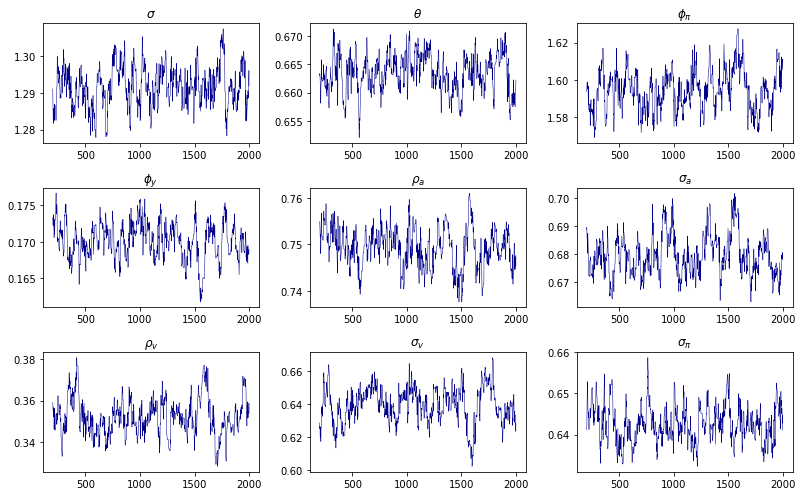

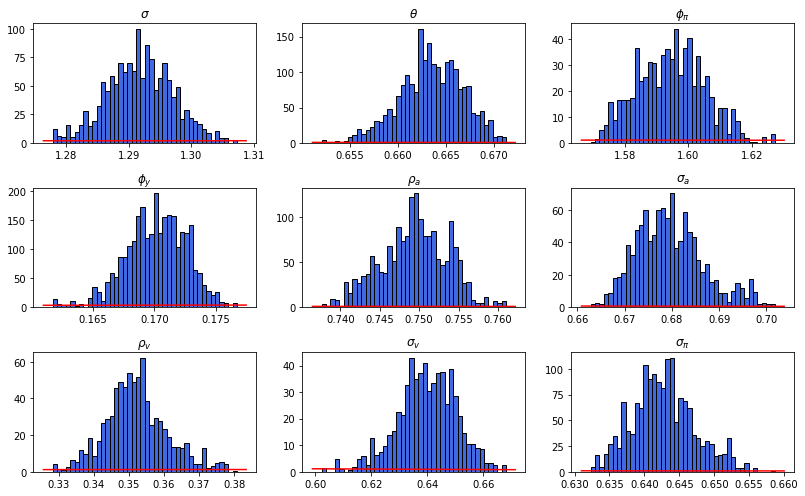

In [24]:
dsge.eval_chains(burnin=0.1, show_charts=True, conf=0.99)

After the estimation, the DSGE model obsject earns the `posterior_table` attribute, which contains a pandas DataFrame
with the tradional measures reported on academic papers.

In [25]:
dsge.posterior_table

,prior dist,prior mean,prior std,posterior mode,posterior mean,posterior 1.0%,posterior 99.0%
sigma,normal,1.3,0.2,1.291440,1.291752,1.278457,1.304997
theta,beta,0.6,0.2,0.663177,0.663475,0.655195,0.670687
phi_pi,normal,1.5,0.35,1.583428,1.594462,1.572360,1.624143
phi_y,gamma,0.25,0.1,0.170122,0.170138,0.162219,0.175657
rho_a,beta,0.5,0.25,0.748421,0.749346,0.738941,0.760301
sigma_a,invgamma,0.5,0.25,0.677895,0.679622,0.665022,0.699446
rho_v,beta,0.5,0.25,0.341126,0.352160,0.329273,0.377094
sigma_v,invgamma,0.5,0.25,0.649834,0.639737,0.607226,0.663857
sigma_pi,invgamma,0.5,0.25,0.645097,0.642735,0.633078,0.654611


After running the `eval_chains` method, we can ask for the impulse-response functions of the model.

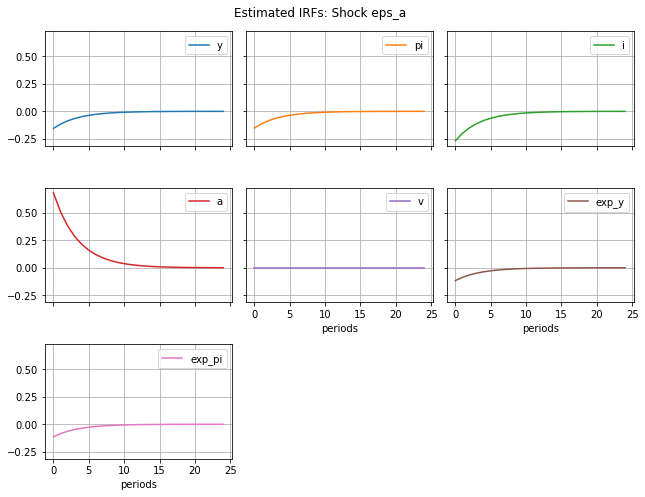

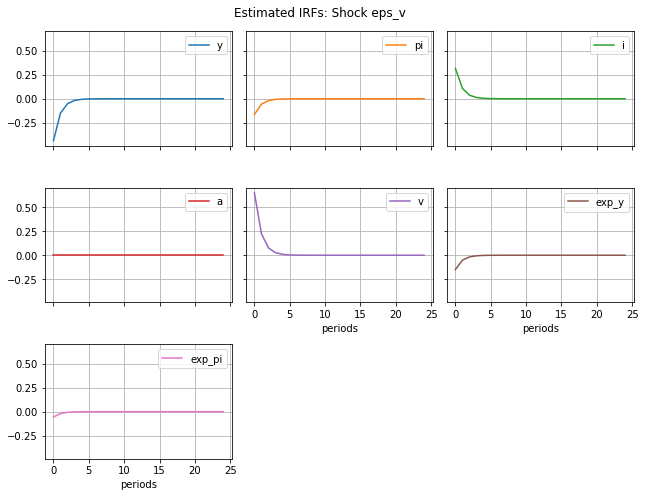

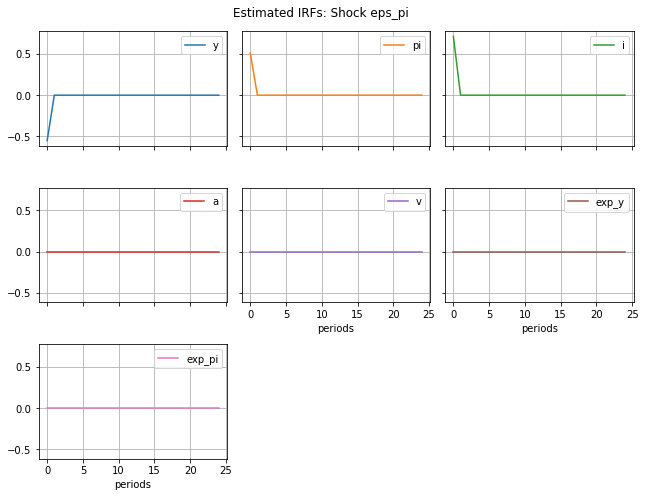

In [26]:
df_irf = dsge.irf(periods=24, show_charts=True)